In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies

In [2]:
# Tried a few things:
# More convolution layers did not increase accuracy
# BatchNorm helps the training initialy

In [3]:
import torch.nn as nn
from core_functions import SensorSignals

# Model with usual halving of image size and doubling the depth
class CNN_Best(nn.Module):    

    def __init__(self, input_ch, n_filters):
        """input_ch is number of channels in initial image, n_filters is first number of filters."""
        super(CNN_Best, self).__init__()

        k = n_filters

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(input_ch, k, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(k),
            nn.ReLU(),
            nn.Conv1d(k, 2*k, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(2*k),
            nn.ReLU(),
            nn.Conv1d(2*k, 4*k, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(4*k),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(4*k * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

    
class CNN_5(nn.Module):    
    def __init__(self):
        super(CNN_5, self).__init__()

        self.conv = nn.Sequential(    # Convolutional part, 3 layers
            nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=1),
            nn.Conv1d(4, 4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1),
            nn.Conv1d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.Conv1d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        self.fc = nn.Sequential(        # Fully connected part, 3 layers
            nn.Linear(16 * 4, 256),
            nn.ReLU(),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [4]:
dataPath = "./second_collection_triggs_rels_32.npz"
S = SensorSignals(dataPath) 
S.split_data()
S.norm_X()
S.setup_tensors()
S.print_shapes()

(1, 1, 1)
Normalizing dataset from [3.07030589] to
[1.]
Normalizing dataset from [3.07895111] to
[1.00281575]
Normalizing dataset from [3.07273222] to
[1.00079026]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7498, 1, 32)
Labels shape:  (7498,)
Unique labels:  [0 1 2]
Shape of test set: (1125, 1, 32)
Shape of train set: (5417, 1, 32)
Shape of validation set: (956, 1, 32)
Fraction of single class in test set:  0.32355555555555554


In [5]:
# for CNN_STANDARD
# lr=5e-3, wd=1e-4
# with BatchNorm1d
# lr=1e-2, wd=1e-3

models = [CNN_Best(input_ch=1, n_filters=8)]
S.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=256, max_epochs=50)

Epoch 1, Batch 1: loss=1.309, train=52.8%, val=50.9%
Epoch 2, Batch 1: loss=0.604, train=75.9%, val=75.6%
Epoch 3, Batch 1: loss=0.424, train=81.9%, val=81.0%
Epoch 4, Batch 1: loss=0.439, train=80.0%, val=79.2%
Epoch 5, Batch 1: loss=0.325, train=81.4%, val=80.4%
Epoch 6, Batch 1: loss=0.339, train=85.0%, val=83.8%
Epoch 7, Batch 1: loss=0.335, train=84.8%, val=84.6%
Epoch 8, Batch 1: loss=0.261, train=88.5%, val=88.2%
Epoch 9, Batch 1: loss=0.233, train=88.7%, val=88.5%
Epoch 10, Batch 1: loss=0.330, train=85.6%, val=85.3%
Epoch 11, Batch 1: loss=0.260, train=87.9%, val=86.4%
Epoch 12, Batch 1: loss=0.270, train=89.8%, val=90.0%
Epoch 13, Batch 1: loss=0.356, train=85.0%, val=84.0%
Epoch 14, Batch 1: loss=0.338, train=88.6%, val=88.0%
Epoch 15, Batch 1: loss=0.189, train=90.6%, val=89.1%
Epoch 16, Batch 1: loss=0.251, train=90.8%, val=89.1%
Epoch 17, Batch 1: loss=0.250, train=87.4%, val=86.1%
Epoch 18, Batch 1: loss=0.260, train=90.4%, val=88.6%
Epoch 19, Batch 1: loss=0.185, train=

Accuracy of test set of best model (idx=0): 89.9%


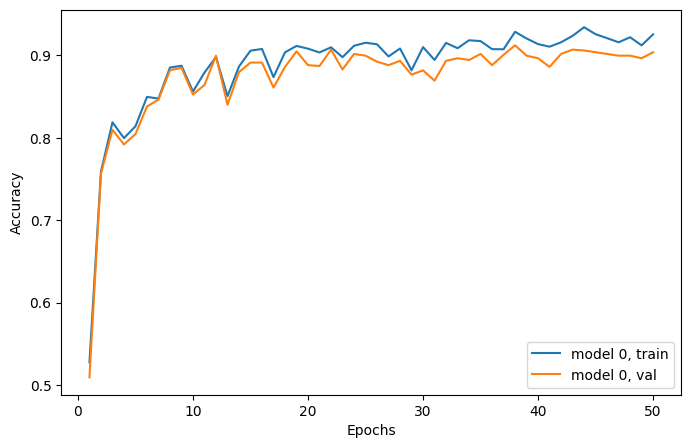

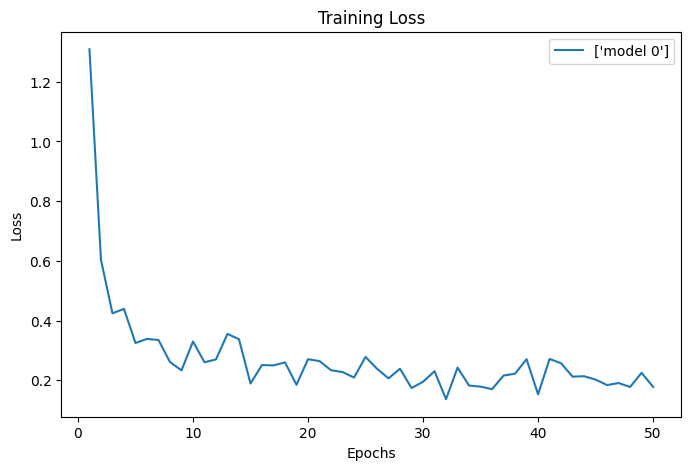

In [6]:
S.plotAcc()
S.plotLosses()
S.bestModelAcc()

In [7]:
D = SensorSignals("./second_collection_triggs_rels_32.npz") 
D.split_data()
D.norm_X()
D.resample_channels()
D.setup_tensors()
D.print_shapes()

(1, 1, 1)
Normalizing dataset from [3.07030589] to
[1.]
Normalizing dataset from [3.07895111] to
[1.00281575]
Normalizing dataset from [3.07273222] to
[1.00079026]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7498, 1, 32)
Labels shape:  (7498,)
Unique labels:  [0 1 2]
Shape of test set: (5625, 3, 32)
Shape of train set: (27085, 3, 32)
Shape of validation set: (4780, 3, 32)
Fraction of single class in test set:  0.32355555555555554


In [8]:
models = [CNN_Best(input_ch=3, n_filters=16)]
D.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=128, max_epochs=5)

Epoch 1, Batch 1: loss=1.263, train=36.3%, val=35.4%
Epoch 1, Batch 101: loss=0.188, train=93.9%, val=92.6%
Epoch 1, Batch 201: loss=0.128, train=93.9%, val=93.3%
Epoch 2, Batch 1: loss=0.122, train=95.7%, val=95.1%
Epoch 2, Batch 101: loss=0.153, train=94.7%, val=94.5%
Epoch 2, Batch 201: loss=0.094, train=95.2%, val=94.3%
Epoch 3, Batch 1: loss=0.119, train=96.0%, val=95.3%
Epoch 3, Batch 101: loss=0.110, train=96.2%, val=95.6%
Epoch 3, Batch 201: loss=0.127, train=96.5%, val=95.8%
Epoch 4, Batch 1: loss=0.064, train=96.5%, val=95.4%
Epoch 4, Batch 101: loss=0.089, train=97.1%, val=96.4%
Epoch 4, Batch 201: loss=0.031, train=97.1%, val=96.5%
Epoch 5, Batch 1: loss=0.041, train=96.7%, val=95.5%
Epoch 5, Batch 101: loss=0.048, train=97.2%, val=96.4%
Epoch 5, Batch 201: loss=0.082, train=96.6%, val=95.6%
Training Complete!


Accuracy of test set of best model (idx=0): 96.9%


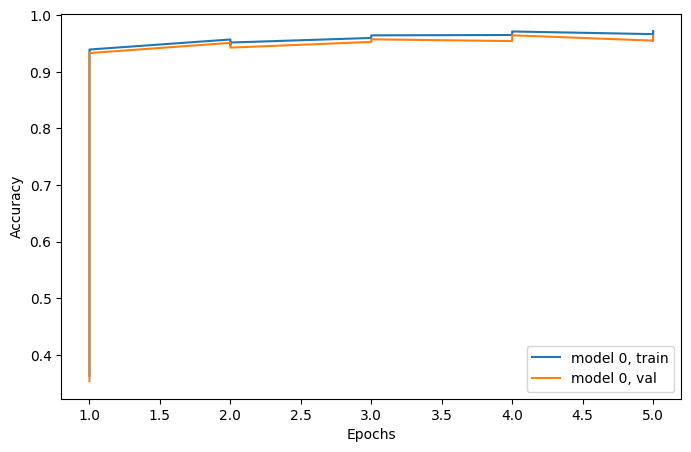

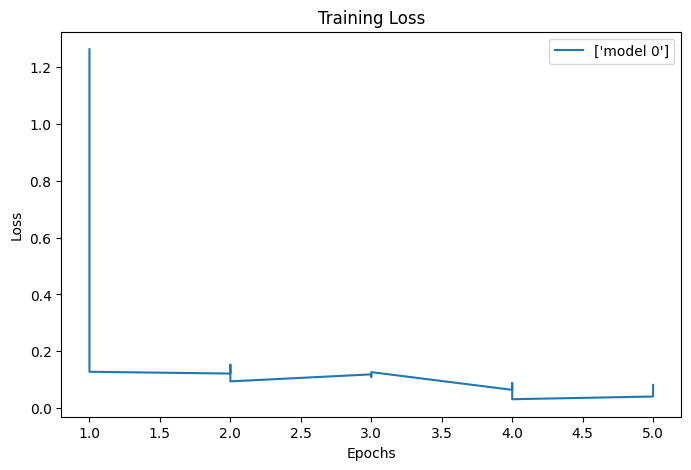

In [9]:
D.plotAcc()
D.plotLosses()
D.bestModelAcc()

In [10]:
# Look into using triggers and releases in two separate channels
E = SensorSignals("./second_collection_triggs_rels_32.npz", triggers=True, releases=True) 
E.split_data()
E.norm_X()
# E.resample_channels()
E.setup_tensors()
E.print_shapes()

(1, 2, 1)
Normalizing dataset from [3.07030589 2.89853221] to
[1. 1.]
Normalizing dataset from [3.07895111 2.90351911] to
[1.00281575 1.00172049]
Normalizing dataset from [3.07273222 2.89892155] to
[1.00079026 1.00013432]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7498, 2, 32)
Labels shape:  (7498,)
Unique labels:  [0 1 2]
Shape of test set: (1125, 2, 32)
Shape of train set: (5417, 2, 32)
Shape of validation set: (956, 2, 32)
Fraction of single class in test set:  0.32355555555555554


In [11]:
models = [CNN_Best(input_ch=2, n_filters=16)]
E.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=100)

Epoch 1, Batch 1: loss=1.526, train=53.2%, val=52.5%
Epoch 2, Batch 1: loss=0.720, train=64.3%, val=64.6%
Epoch 3, Batch 1: loss=0.612, train=73.2%, val=74.5%
Epoch 4, Batch 1: loss=0.541, train=79.8%, val=79.5%
Epoch 5, Batch 1: loss=0.421, train=83.3%, val=82.3%
Epoch 6, Batch 1: loss=0.420, train=84.6%, val=83.6%
Epoch 7, Batch 1: loss=0.363, train=84.0%, val=82.1%
Epoch 8, Batch 1: loss=0.344, train=85.9%, val=83.3%
Epoch 9, Batch 1: loss=0.348, train=87.3%, val=84.3%
Epoch 10, Batch 1: loss=0.278, train=89.1%, val=87.8%
Epoch 11, Batch 1: loss=0.261, train=90.3%, val=87.0%
Epoch 12, Batch 1: loss=0.252, train=89.4%, val=85.1%
Epoch 13, Batch 1: loss=0.297, train=87.4%, val=84.0%
Epoch 14, Batch 1: loss=0.274, train=89.2%, val=86.3%
Epoch 15, Batch 1: loss=0.275, train=90.5%, val=87.2%
Epoch 16, Batch 1: loss=0.272, train=90.8%, val=86.0%
Epoch 17, Batch 1: loss=0.240, train=89.2%, val=86.8%
Epoch 18, Batch 1: loss=0.283, train=90.9%, val=88.9%
Epoch 19, Batch 1: loss=0.172, train=

Accuracy of test set of best model (idx=0): 90.2%


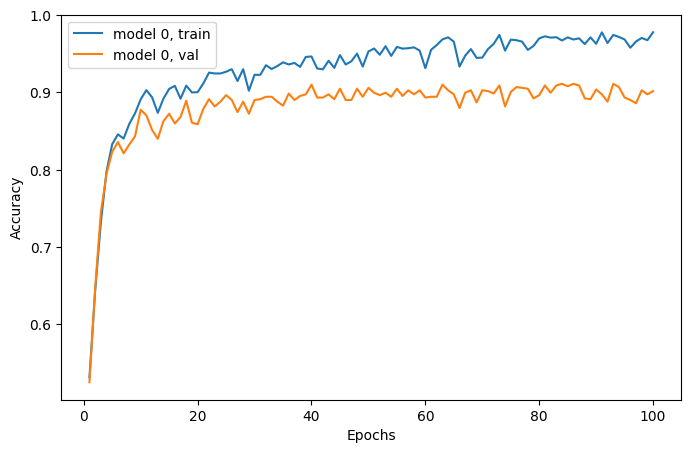

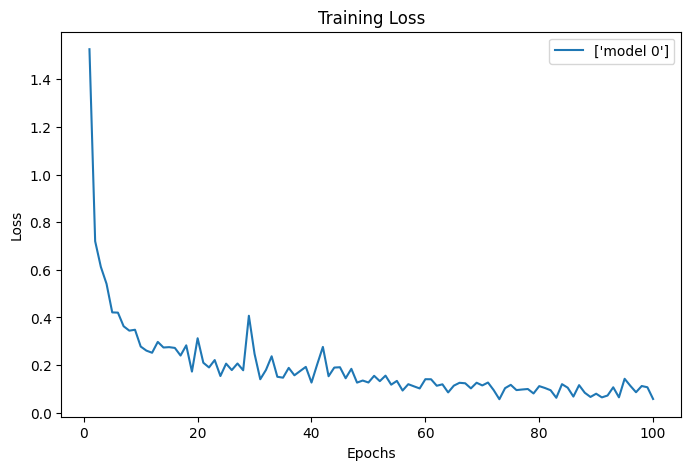

In [12]:
E.plotAcc()
E.plotLosses()
E.bestModelAcc()